In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
dataset = load_dataset("trec")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [4]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'coarse_label' : train_dataset['coarse_label']})
test_df = pd.DataFrame({'text' : test_dataset['text'], 'coarse_label' : test_dataset['coarse_label']})

In [5]:
train_df.head()

,text,coarse_label
0,How did serfdom develop in and then leave Russ...,2
1,What films featured the character Popeye Doyle ?,1
2,How can I find a list of celebrities ' real na...,2
3,What fowl grabs the spotlight after the Chines...,1
4,What is the full form of .com ?,0


In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['coarse_label'])

# Spliting Data into train_encodings, test_encodings

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [8]:
train_encodings = tokenizer(initial_labeled_set['text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.coarse_label.to_list()
test_labels = test_df.coarse_label.to_list()

In [9]:
num_labels = 6
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [11]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=5,  # Reduced number of epochs.
    per_device_train_batch_size=10,  # Reduced batch size for training.
    per_device_eval_batch_size=20,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    #fp16=True,  # Enable mixed precision training.
)

In [12]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [13]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [14]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [15]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [16]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [18]:
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 19.0% 


## An Active Learning Approach Based On Uncertain Sampling

In [19]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,text,coarse_label
1693,In what city is the US Declaration of Independ...,4
3374,What animal do buffalo wings come from ?,1
5228,How many gallons of paint does it take to pain...,5
3268,Who were leaders of the Byzantine empire ?,3
3389,What are the components of polyester ?,1


In [20]:
initial_labeled_set.shape

(272, 2)

# 

In [21]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [22]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.coarse_label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'text' : data['text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['coarse_label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [23]:
test_df['coarse_label'].skew()

0.09677453168815325

# Simulated Active Learning

In [24]:
initial_labeled_set = test_df.head(150)

In [25]:
initial_labeled_set

,text,coarse_label
0,How far is it from Denver to Aspen ?,5
1,"What county is Modesto , California in ?",4
2,Who was Galileo ?,3
3,What is an atom ?,2
4,When did Hawaii become a state ?,5
...,...,...
145,What is the longest bone in the human body ?,1
146,Who is a German philosopher ?,3
147,What were Christopher Columbus ' three ships ?,1
148,What does Phi Beta Kappa mean ?,2


In [26]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set)

  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
hundreds_rows_pred

,coarse_label,text,predicted_Label,predicted_Probability,Entropy
125,3,Which president was unmarried ?,1,0.171128,1.783078
130,5,How far is a nautical mile ?,1,0.124907,1.782442
145,1,What is the longest bone in the human body ?,1,0.108568,1.781374
0,5,How far is it from Denver to Aspen ?,1,0.150489,1.780886
85,2,Why is a ladybug helpful ?,1,0.162209,1.780289
...,...,...,...,...,...
18,2,What is epilepsy ?,1,0.399748,1.748454
116,5,When did the Hindenberg crash ?,1,0.397512,1.746838
82,3,Who was elected president of South Africa in 1...,1,0.392006,1.741314
34,5,When did John F. Kennedy get elected as Presid...,1,0.412573,1.741083


# Active Learning

In [28]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    print(n)
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['text'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].coarse_label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



10


  0%|          | 0/5 [00:00<?, ?it/s]

{'train_runtime': 0.5114, 'train_samples_per_second': 97.772, 'train_steps_per_second': 9.777, 'train_loss': 1.792422103881836, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.188
20


  0%|          | 0/10 [00:00<?, ?it/s]

{'train_runtime': 0.9738, 'train_samples_per_second': 102.69, 'train_steps_per_second': 10.269, 'train_loss': 1.7075851440429688, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.188
30


  0%|          | 0/15 [00:00<?, ?it/s]

{'train_runtime': 1.4402, 'train_samples_per_second': 104.149, 'train_steps_per_second': 10.415, 'train_loss': 1.613396199544271, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.25
40


  0%|          | 0/20 [00:00<?, ?it/s]

{'train_runtime': 1.9866, 'train_samples_per_second': 100.674, 'train_steps_per_second': 10.067, 'train_loss': 1.5203030586242676, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.28
50


  0%|          | 0/25 [00:00<?, ?it/s]

{'train_runtime': 2.3303, 'train_samples_per_second': 107.285, 'train_steps_per_second': 10.728, 'train_loss': 1.413140869140625, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.342
60


  0%|          | 0/30 [00:00<?, ?it/s]

{'train_runtime': 2.813, 'train_samples_per_second': 106.646, 'train_steps_per_second': 10.665, 'train_loss': 1.2275104522705078, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.43
70


  0%|          | 0/35 [00:00<?, ?it/s]

{'train_runtime': 3.3802, 'train_samples_per_second': 103.543, 'train_steps_per_second': 10.354, 'train_loss': 0.9570205688476563, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.662
80


  0%|          | 0/40 [00:00<?, ?it/s]

{'train_runtime': 3.8512, 'train_samples_per_second': 103.864, 'train_steps_per_second': 10.386, 'train_loss': 0.6339600086212158, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.778
90


  0%|          | 0/45 [00:00<?, ?it/s]

{'train_runtime': 4.6515, 'train_samples_per_second': 96.743, 'train_steps_per_second': 9.674, 'train_loss': 0.3714299943712023, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.85
100


  0%|          | 0/50 [00:00<?, ?it/s]

{'loss': 0.1427, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4167182147502899, 'eval_Accuracy': 0.882, 'eval_F1': 0.7354441187764952, 'eval_Precision': 0.9069430255834109, 'eval_Recall': 0.7395116065048674, 'eval_runtime': 0.7489, 'eval_samples_per_second': 667.677, 'eval_steps_per_second': 33.384, 'epoch': 5.0}
{'train_runtime': 5.9528, 'train_samples_per_second': 83.994, 'train_steps_per_second': 8.399, 'train_loss': 0.14271931648254393, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.882
110


  0%|          | 0/55 [00:00<?, ?it/s]

{'loss': 0.0457, 'learning_rate': 2.5e-05, 'epoch': 4.55}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4397538900375366, 'eval_Accuracy': 0.882, 'eval_F1': 0.7399696777794901, 'eval_Precision': 0.9215340406719718, 'eval_Recall': 0.7368712509636414, 'eval_runtime': 0.7582, 'eval_samples_per_second': 659.414, 'eval_steps_per_second': 32.971, 'epoch': 4.55}
{'train_runtime': 6.4908, 'train_samples_per_second': 84.735, 'train_steps_per_second': 8.474, 'train_loss': 0.04284869716926055, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.88
120


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.0174, 'learning_rate': 2.5e-05, 'epoch': 4.17}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4141278862953186, 'eval_Accuracy': 0.908, 'eval_F1': 0.7622344983043433, 'eval_Precision': 0.9295698444770161, 'eval_Recall': 0.7650575466949195, 'eval_runtime': 0.7538, 'eval_samples_per_second': 663.297, 'eval_steps_per_second': 33.165, 'epoch': 4.17}
{'train_runtime': 7.0017, 'train_samples_per_second': 85.693, 'train_steps_per_second': 8.569, 'train_loss': 0.015216178757448991, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.908
130


  0%|          | 0/65 [00:00<?, ?it/s]

{'loss': 0.0127, 'learning_rate': 2.5e-05, 'epoch': 3.85}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5971536636352539, 'eval_Accuracy': 0.894, 'eval_F1': 0.7453410193869754, 'eval_Precision': 0.9130096144738089, 'eval_Recall': 0.754838111666388, 'eval_runtime': 0.7625, 'eval_samples_per_second': 655.72, 'eval_steps_per_second': 32.786, 'epoch': 3.85}
{'train_runtime': 7.576, 'train_samples_per_second': 85.798, 'train_steps_per_second': 8.58, 'train_loss': 0.010059040211714231, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.902
140


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 0.0008, 'learning_rate': 2.5e-05, 'epoch': 3.57}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6326334476470947, 'eval_Accuracy': 0.908, 'eval_F1': 0.762989506136329, 'eval_Precision': 0.9319046956116878, 'eval_Recall': 0.7670004135753374, 'eval_runtime': 0.7569, 'eval_samples_per_second': 660.613, 'eval_steps_per_second': 33.031, 'epoch': 3.57}
{'train_runtime': 8.1224, 'train_samples_per_second': 86.181, 'train_steps_per_second': 8.618, 'train_loss': 0.0006370506116322108, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.916
150


  0%|          | 0/75 [00:00<?, ?it/s]

{'loss': 0.0125, 'learning_rate': 2.5e-05, 'epoch': 3.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6361883282661438, 'eval_Accuracy': 0.918, 'eval_F1': 0.7728764263338236, 'eval_Precision': 0.9382827780660598, 'eval_Recall': 0.775177926139971, 'eval_runtime': 0.7676, 'eval_samples_per_second': 651.411, 'eval_steps_per_second': 32.571, 'epoch': 3.33}
{'train_runtime': 8.5915, 'train_samples_per_second': 87.295, 'train_steps_per_second': 8.73, 'train_loss': 0.008384618774677317, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

eval_Accuracy : 0.92


In [29]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'Label' : test_df['coarse_label'].to_list() }) 

bert_pred_df.to_csv('Trec_coarse_label_Bert_Pred.csv',index=False)

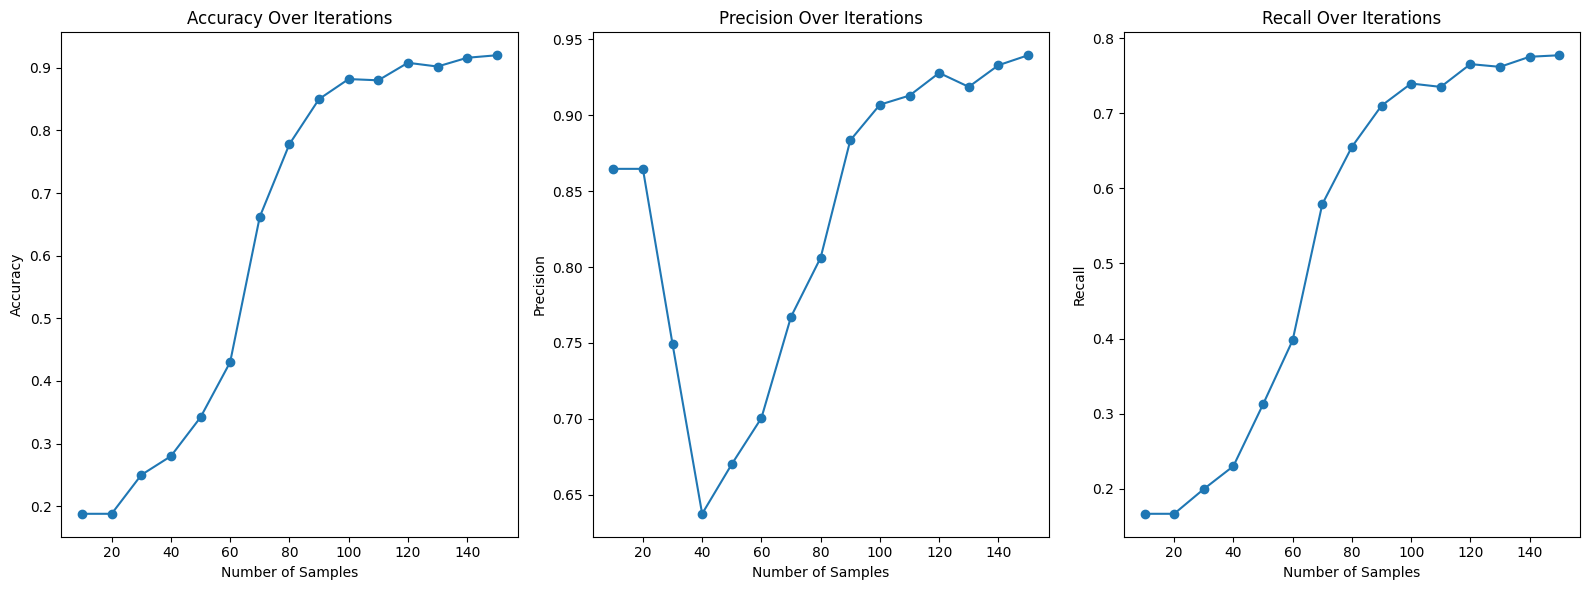

In [30]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [31]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/25 [00:00<?, ?it/s]

accuracy 92.0% 


In [34]:
from sklearn.metrics import confusion_matrix


# Confusion Matrix

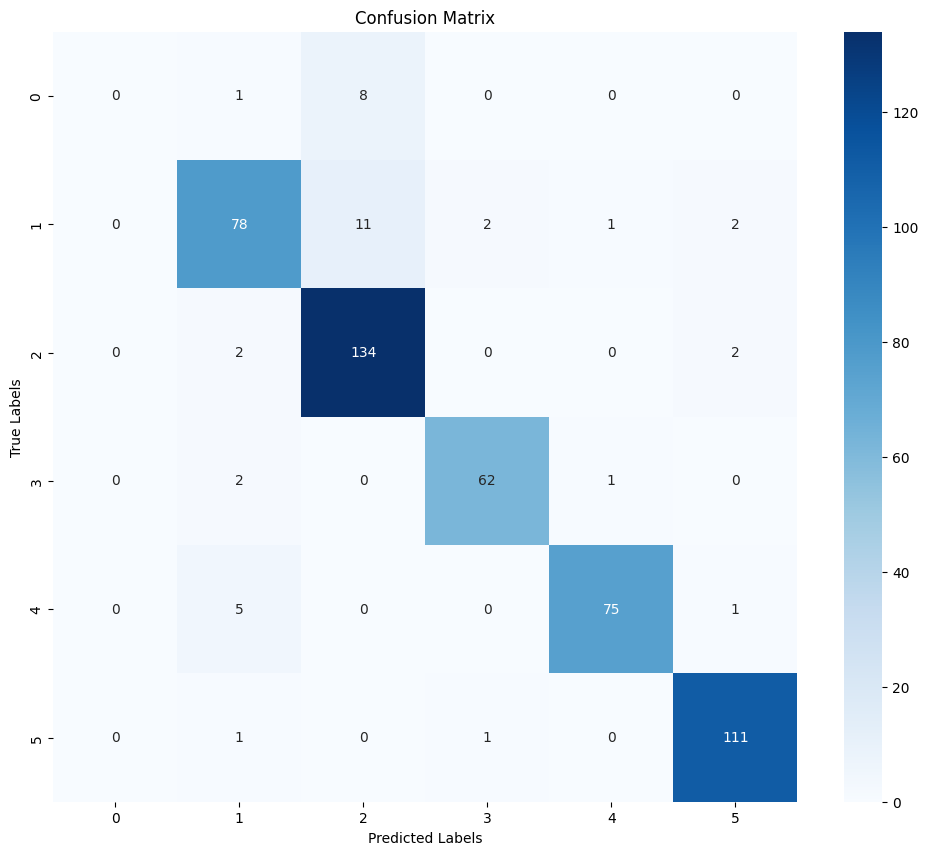

In [35]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['coarse_label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()